<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/TransferLearning_in_TensorFlow_FineTuning_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In the previous notebook, we've covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

## What we're going to cover

* Introduce fine-tuning transfer learning with TensorFlow
* Introduce the `Keras Functional API` to build models
* Using a small dataset to experiment faster (10% of training samples)
* `Data Augmentation` (making your own training set more diverse without adding more samples)
* Running series of experiments on our Food Vision Data
* Introduce the `ModelCheckpoint callback` to save intermediate training results

### Let's Cook

In [1]:
# Let's check our GPU
!nvidia-smi

Sat Mar  9 09:28:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good practice to put all the functions together in a helper.py script for future use in the projects. Now you can download and import those functions into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-09 09:28:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-09 09:28:46 (62.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑**Note:** If you're running this notebook in Google Colab, when it times out, Colab will delete `helper_functions.py`, So you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing food items)

[Keras API](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [4]:
# Get 10% of the training data of Food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2024-03-09 09:28:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.0MB/s    in 8.1s    

2024-03-09 09:28:59 (19.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Let's walk through the directories and look at our data
walk_through_dir('10_food_classes_10_percent')


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'


In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Instead of ImageDataGenerator, we're going to use image_dataset_from_directory
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):

  print(images, labels)

tf.Tensor(
[[[[  0.         0.         2.      ]
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]
   ...
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]]

  [[  0.         0.         2.      ]
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]
   ...
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]]

  [[  0.         0.         2.      ]
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]
   ...
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]]

  ...

  [[  0.         0.         2.      ]
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]
   ...
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]
   [  0.         0.         2.      ]]

  [[  0.         0.         2.    

## Building a Transfer Learning Model using Functional API

We're going to use `tf.keras.applications` and this is how are experimenation flow is gonna look like:

`Model_0 (baseline)` -> `Model_1 (preprocessing 1% data)` -> `Model_2 (preprocessing 10% data)` -> `Model_3 (Fine-Tune)` -> `Model_4 (Full Data)`

* **Similarities:** Compiling, Fitting, Evaluating
* **Differences:** [Functional API](https://www.tensorflow.org/guide/keras/functional_api) is more flexible and able to produce more sophisticated models

In [11]:
# Using keras functional API and create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# Freeze the base model (so the pre-learned patterns remain unchanged)
base_model.trainable = False

# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# If using ResNet50V2 you will need to normalize inputs, This will speed up the convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base_model
x = base_model(inputs)

# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# outputs of the model
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model with inputs and outputs
model_0 = tf.keras.Model(inputs=inputs, outputs=outputs, name='Model_0')

# Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_0 = model_0.fit(train_data_10_percent, epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                              experiment_name='model_0')])


24274472/24274472 [==============================] - 2s 0us/step
Saving TensorBoard log files to: transfer_learning/model_0/20240309-092911
Epoch 1/5
24/24 [==============================] - 20s 370ms/step - loss: 1.9044 - accuracy: 0.4267 - val_loss: 1.3501 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 5s 198ms/step - loss: 1.1557 - accuracy: 0.7467 - val_loss: 0.8955 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 3s 123ms/step - loss: 0.8546 - accuracy: 0.8040 - val_loss: 0.7125 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 4s 169ms/step - loss: 0.6920 - accuracy: 0.8400 - val_loss: 0.5935 - val_accuracy: 0.8766
Epoch 5/5
24/24 [==============================] - 4s 169ms/step - loss: 0.5892 - accuracy: 0.8747 - val_loss: 0.5623 - val_accuracy: 0.8536


In [12]:
# Let's evaluate the model_0
model_0.evaluate(test_data)

79/79 [==============================] - 7s 90ms/step - loss: 0.5690 - accuracy: 0.8580


[0.568987250328064, 0.8579999804496765]

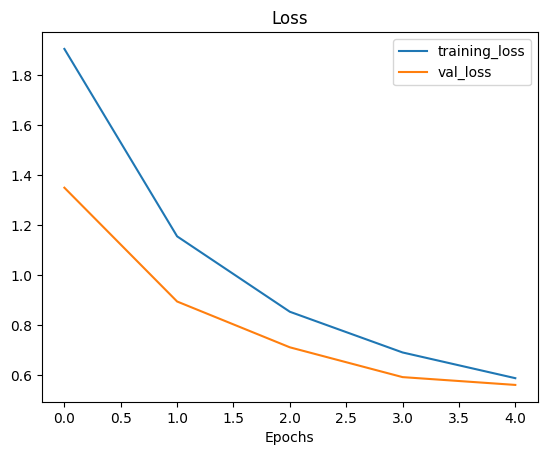

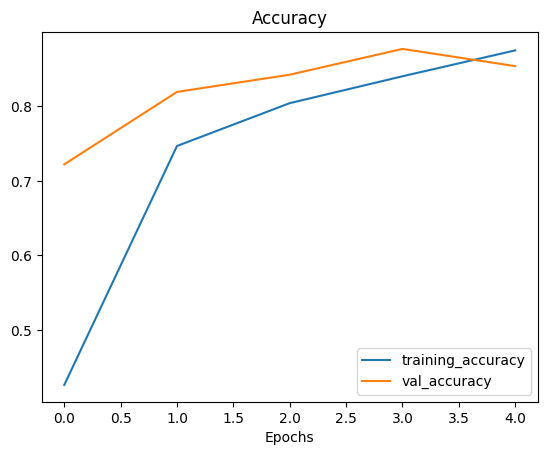

In [13]:
# Let's look at the loss and accuracy curves from history_0
plot_loss_curves(history_0)

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [15]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [16]:
# How about a summary of our whole model
model_0.summary()

Model: "Model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
________________

In [17]:
# Let's look at the confusion matrix
from helper_functions import make_confusion_matrix
import numpy as np

y_true = []
y_pred = []

# Iterate over the test data to collect true labels and predicted labels
for images, labels in test_data:
    y_true.extend(tf.argmax(labels, axis=1))  # Assuming one-hot encoded labels
    y_pred.extend(tf.argmax(model_0.predict(images, verbose=0), axis=1))

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


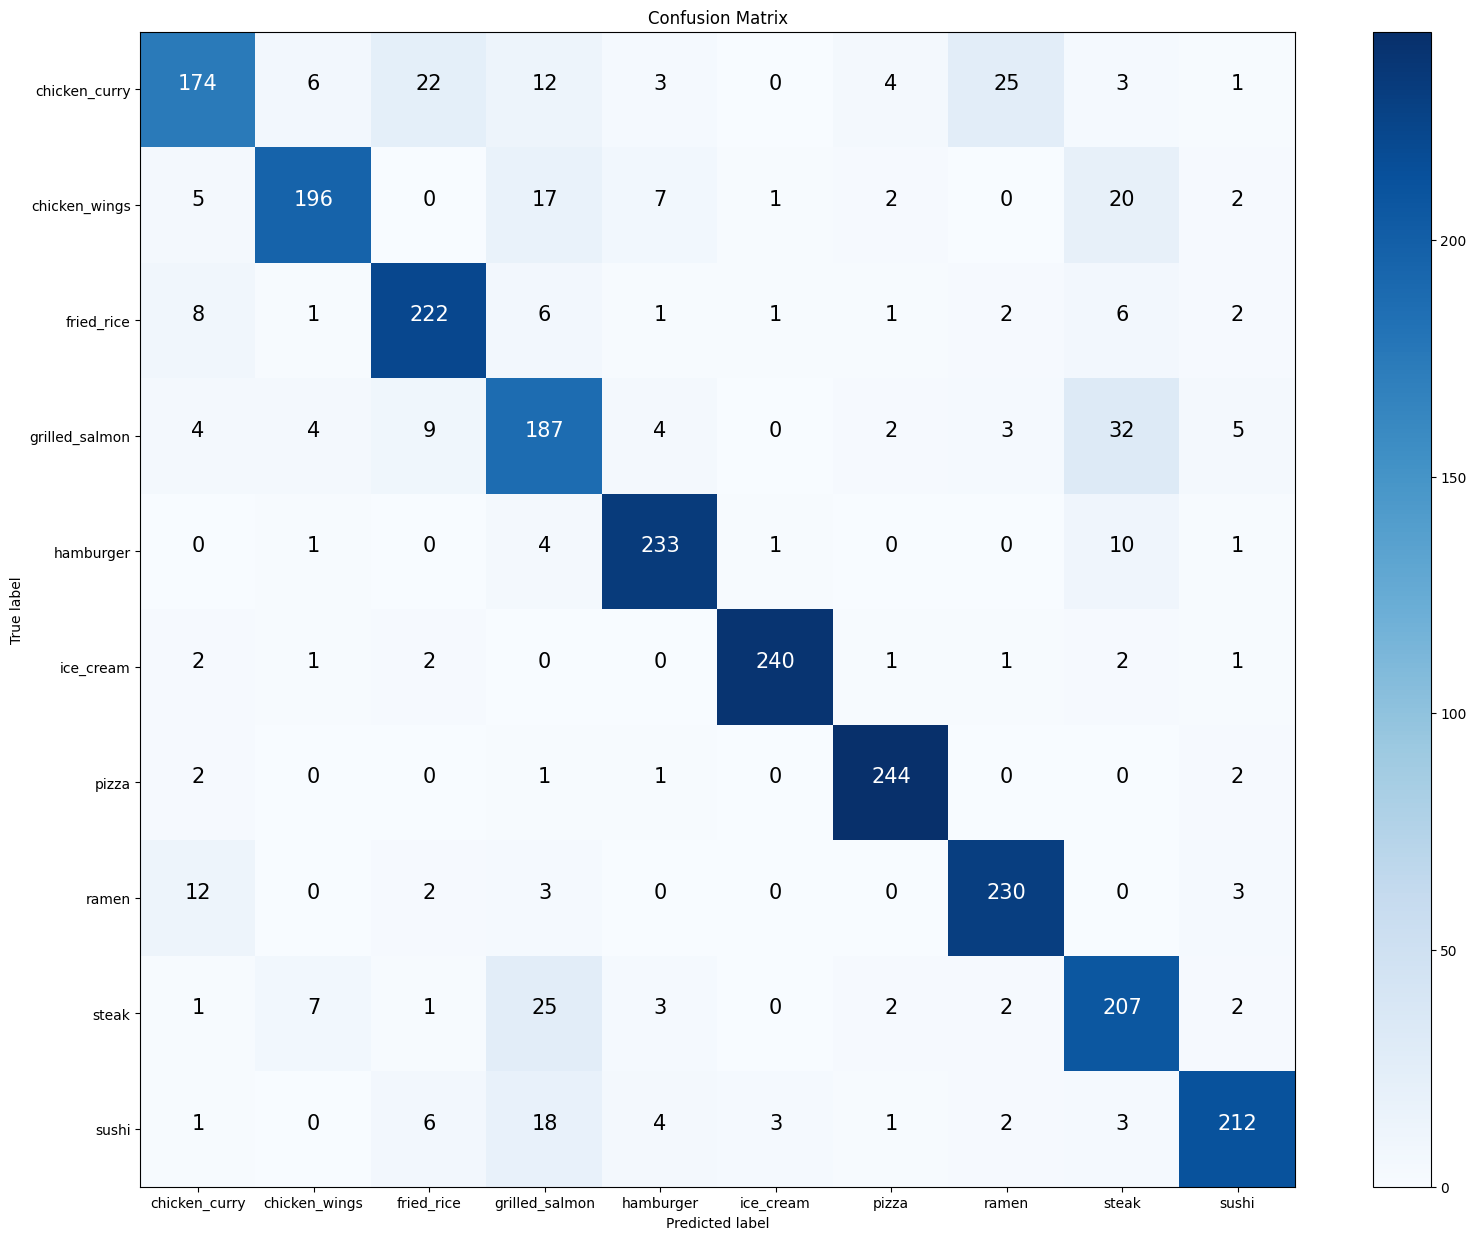

In [18]:
# Call the make_confusion_matrix function
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=test_data.class_names, figsize=(20, 15))

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, None, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [19]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)  # Same as tf.reduce_mean(input_tensor, axis=[1, 2])
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n"
      f"Shape of tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of tensor: (1, 3)


In [20]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> 📑**Practice:** Try to do the same with the two cells but this time use `GlobalMaxPool2D`... and see what happens.

>🔑**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use the feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning learning on 100% of the training data with data augmentation

🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

In [22]:
# Download and unzip data
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2024-03-09 09:35:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.2MB/s    in 6.6s    

2024-03-09 09:35:31 (19.2 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# Let's walk through our new dataset and have a look at it
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [24]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"


### Getting and preprocessing data for model_1

In [25]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32 )

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding a data augmentation layer into our model

To add data augmentation right into our models, we can use the layers inside:

* [`tf.keras.layers.experimental.preprocessing()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)

We can see the benifits of doing this within the TensorFlow Data Augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [26]:
# Add data augmentation layer to our model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # keep for models like ResNet50V2, remove for EfficientNet
  # preprocessing.Rescaling(1./255)
], name="data_augmentation")


### Visualize our Data Augmentation Layer (and see what happens to our data)

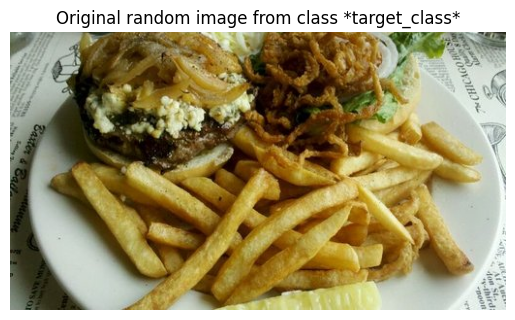

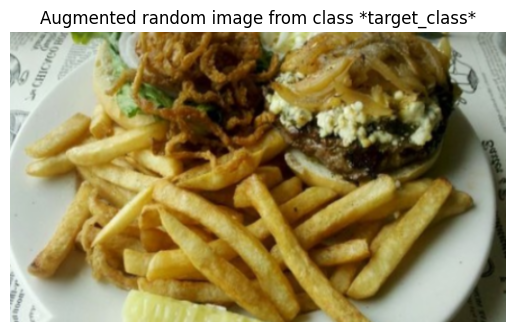

In [33]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(f"10_food_classes_1_percent/train/{target_class}")) # choose a random image per class
random_image_path = f"10_food_classes_1_percent/train/{target_class}/{random_image}"

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class *target_class*')
plt.axis(False);

# Augment the random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented random image from class *target_class*')
plt.axis(False);

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [40]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in the data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=True)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name='transfer learning',
                                                                       experiment_name='Model_1')])


Saving TensorBoard log files to: transfer learning/Model_1/20240309-103457
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.3206 - accuracy: 0.1286 - val_loss: 2.2073 - val_accuracy: 0.1924
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0626 - accuracy: 0.3000 - val_loss: 2.1062 - val_accuracy: 0.2303
Epoch 3/5
3/3 [==============================] - 2s 873ms/step - loss: 1.9110 - accuracy: 0.4429 - val_loss: 1.9908 - val_accuracy: 0.3322
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7414 - accuracy: 0.5286 - val_loss: 1.8955 - val_accuracy: 0.4030
Epoch 5/5
3/3 [==============================] - 2s 852ms/step - loss: 1.5425 - accuracy: 0.6429 - val_loss: 1.8117 - val_accuracy: 0.4375


In [41]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [42]:
# Evaluate on full data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.8262 - accuracy: 0.4364


[1.8262474536895752, 0.43639999628067017]

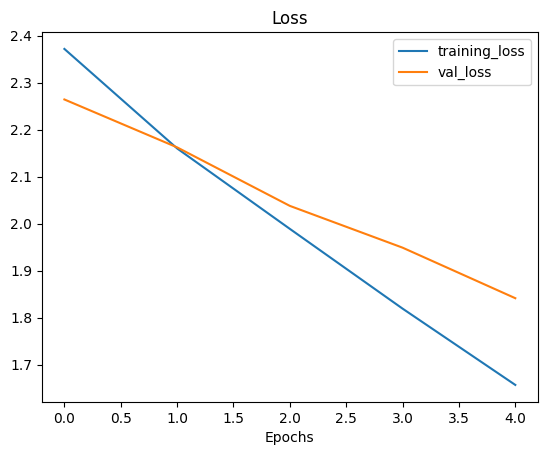

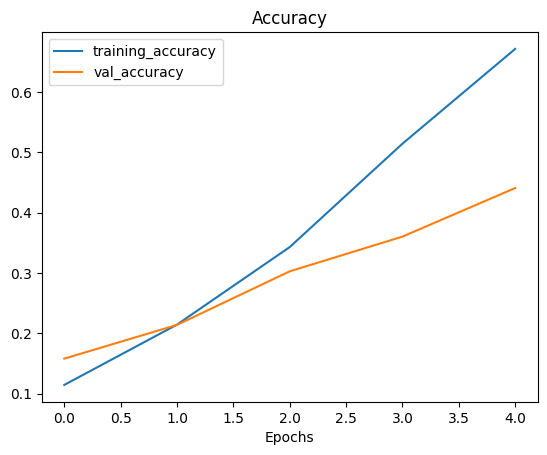

In [43]:
# How does the model with 1% of the data augmentation loss curves look
plot_loss_curves(history_1)

## Model_2: Feature Extraction transfer learning with 10% of data and data augmentation

In [44]:
# Setup inputs, base model, freeze the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in the data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=True)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        # Track model training logs
                        callbacks=[create_tensorboard_callback(dir_name='transfer learning',
                                                               experiment_name='Model_2')])


Saving TensorBoard log files to: transfer learning/Model_2/20240309-103548
Epoch 1/5
24/24 [==============================] - 17s 335ms/step - loss: 1.9785 - accuracy: 0.3387 - val_loss: 1.4806 - val_accuracy: 0.6859
Epoch 2/5
24/24 [==============================] - 6s 241ms/step - loss: 1.3348 - accuracy: 0.6933 - val_loss: 1.0190 - val_accuracy: 0.7747
Epoch 3/5
24/24 [==============================] - 7s 266ms/step - loss: 1.0182 - accuracy: 0.7653 - val_loss: 0.8169 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 5s 196ms/step - loss: 0.8526 - accuracy: 0.7987 - val_loss: 0.7093 - val_accuracy: 0.8487
Epoch 5/5
24/24 [==============================] - 5s 211ms/step - loss: 0.7464 - accuracy: 0.8147 - val_loss: 0.6641 - val_accuracy: 0.8405


In [45]:
# let's Evaluate on the full test set
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 69ms/step - loss: 0.6431 - accuracy: 0.8448


[0.6431267857551575, 0.8447999954223633]

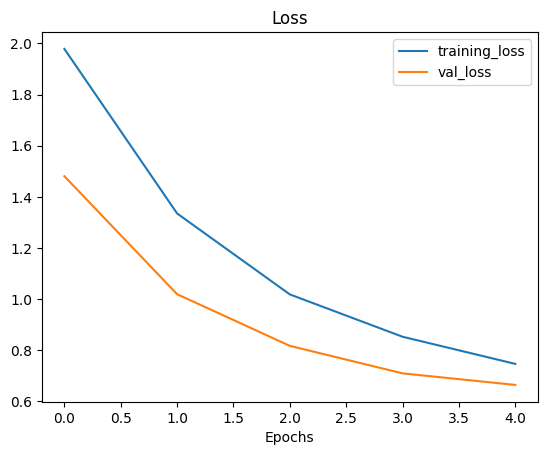

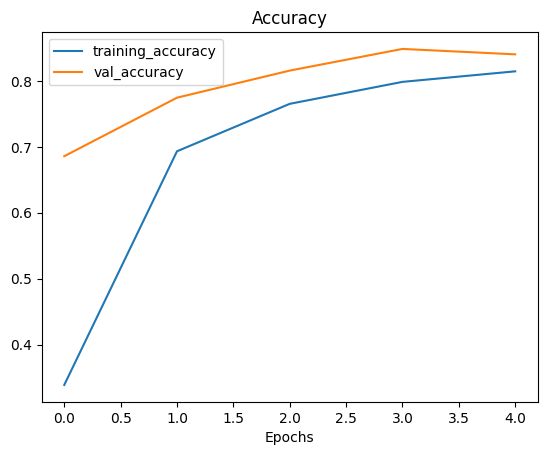

In [46]:
# loss curves
plot_loss_curves(history_2)